# Esempio analisi dati binari FERS

Fonte: [esempio di Valerio](https://baltig.infn.it/mascagna/janus2root/-/blob/main/janus2root.py)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sys, os, re, glob

from datetime import datetime as dt

In [2]:
# File header according to the Janus software manual pag 38
#
# Binary file structure memo:
# 
# [FILE HEADER] +
#   nevents x 
#            [EVENT HEADER] + 
#            64 x [DATA]


# Common to all acquisition modes:

Janus_file_header = np.dtype(
    [
        ("data_format_version", ("B", 2)),  # 16 bits, Data Format Version
        ("software_version", ("B", 3)),  # 24 bits, Data Format Version
        ("acq_mode", np.dtype("B")),  # 8  bits, Acq Mode
        ("time_unit", np.dtype("B")),  # 8  bits, Time Unit # new v3
        ("energy_n_channels",np.dtype(">u2")),  # 16  bits, Energy NChannels # new v3
        ("time_conversion", np.dtype("<f4")), # 32 bits, Time Conversion # new v3
        ("acq_start", np.dtype("u8"))  # 64 bits, Start Acquisition
    ]
)

# Acquisition modes dict (just to print them)

acq_modes = {
    1: "Spectroscopy mode",
    2: "Timing Mode",
    3: "Spectroscopy + Timing Mode",
    4: "Counting Mode"
}

# Dictionaries with the 4 different event schema
# TODO: it would be convenient to put it in an
# external file (json)

# before, the event schema to be repeated 64 times

Janus_event_data_schema = {
    1: np.dtype(  # data for event in spectroscopy mode
        [
            ("channel_id", np.dtype("B")),
            ("data_type", np.dtype("B")),
            ("lg_pha", np.int16),
            ("hg_pha", np.int16),
        ]
    )
}

# now the general event schema
# NOTA: Rispetto a valerio, noi salviamo solo 4 matrici

Janus_event_schema = {
    1: np.dtype(
        [
            ("event_size", np.dtype("u2")),
            ("board_id", np.dtype("B")),
            ("trigger_time_stamp", np.dtype("f8")),
            ("trigger_id", np.dtype("u8")),
            ("channel_mask", np.dtype("u8")),
            ("ch_data", (Janus_event_data_schema[1], 4)),  # 64 times the data schema
        ]
    )
}




In [3]:
# Some useful formatting functions

def better_print(byte_seq):
    '''Just a nice representation of
    arrays of 1 byte integers (file header)
    Example "1.1" instead of "array[1,1]"'''

    return ".".join([str(n) for n in byte_seq])


def better_timestamp_print(millisec_timestamp):
    return dt.fromtimestamp(millisec_timestamp / 1000).strftime("%c")


def print_file_info(file_header_data):
    print("Data Format Version: " + better_print(file_header_data["data_format_version"][0]))
    print("Software Version: " + better_print(file_header_data["software_version"][0]))
    print("Acquisition Mode: " + str(file_header_data["acq_mode"][0]))
    print("Time Unit: " + str(file_header_data["time_unit"][0]))
    print("Energy N Channels: " + str(file_header_data["energy_n_channels"][0]) + " bins")
    print("Time Conversion: " + str(file_header_data["time_conversion"][0]) + " ns/LSB")
    print("Acquisition Time: " + better_timestamp_print(file_header_data["acq_start"]))


In [4]:
input_file_name = "data/Run247_list.dat"

with open(input_file_name, "rb") as fp:

        # File header, 1 time
        head = np.fromfile(fp, dtype=Janus_file_header, count=1)

        #print_file_info(head)

        # Events, count=-1 makes it run until the end of the file
        acq_mode = head["acq_mode"][0]
        data = np.fromfile(fp, dtype=Janus_event_schema[acq_mode], count=-1)


Questi sono i campi che esistono, come definiti dal tipo di file

```
        f["t"] = {
            "trigID" : data['trigger_id'],
            "triggerTimeStamp" : data['trigger_time_stamp'],
            "boardID": data['board_id'],
            "channelMask": data['channel_mask'],
#            "nev5bits": nev5bits,
            "lg": data["ch_data"]["lg_pha"],
            "hg": data["ch_data"]["hg_pha"]
        }
```

In [5]:
data["ch_data"]["lg_pha"].shape

(1973710, 4)

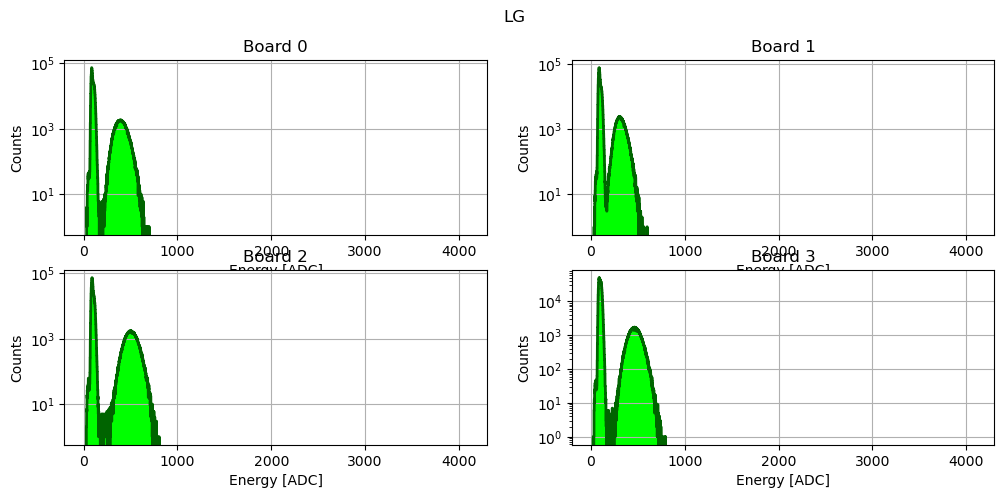

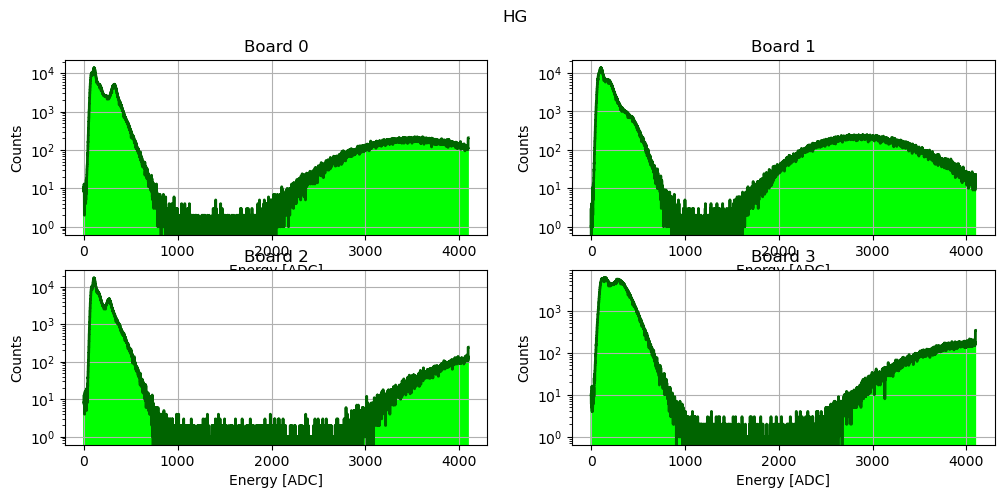

In [6]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 5)
ax = ax.flatten()

fig.suptitle("LG")


for i in range(4):
    
    # Istogrammo i dati
    h, bins = np.histogram(data["ch_data"]["lg_pha"][:,i], range = (0, 4096), bins = 4096)
    binc = bins[:-1] + (bins[1]-bins[0])/2
    
    # Li plotto
    ax[i].plot(binc, h, ds = "steps-mid", c = "darkgreen", lw = 2, label = "Spettro")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)

    ax[i].set_xlabel("Energy [ADC]")
    ax[i].set_ylabel("Counts")
    ax[i].set_title(f"Board {i}")
    
    ax[i].set_yscale("log")
    ax[i].grid()
    
    
plt.show()


fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 5)
ax = ax.flatten()

fig.suptitle("HG")


for i in range(4):
    
    # Istogrammo i dati
    h, bins = np.histogram(data["ch_data"]["hg_pha"][:,i], range = (0, 4096), bins = 4096)
    binc = bins[:-1] + (bins[1]-bins[0])/2
    
    # Li plotto
    ax[i].plot(binc, h, ds = "steps-mid", c = "darkgreen", lw = 2, label = "Spettro")
    ax[i].fill_between(binc, h, step = "mid", color = "lime", alpha = 1)

    ax[i].set_xlabel("Energy [ADC]")
    ax[i].set_ylabel("Counts")
    ax[i].set_title(f"Board {i}")
    
    ax[i].set_yscale("log")
    ax[i].grid()
    
    
plt.show()
    




In [7]:
import copy 
import matplotlib as mpl

# Esistono problemi con i pixels zero: li risolvo 
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

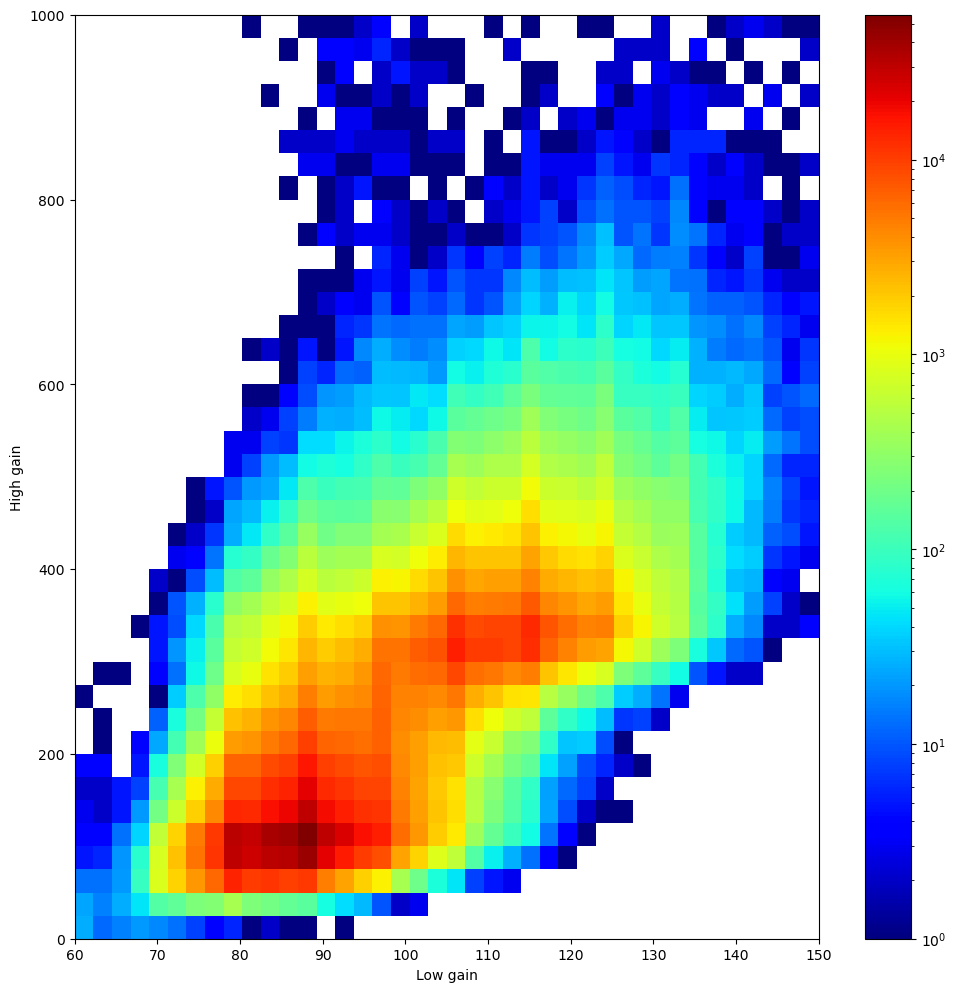

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)



h = ax.hist2d( data["ch_data"]["lg_pha"][:,0], data["ch_data"]["hg_pha"][:,0], bins = 40, range = ((60, 150), (0, 1000)) ,
         norm = mpl.colors.LogNorm(), cmap = mpl.cm.jet)

# ax.set_ylim(0, 1000)
fig.colorbar(h[3], ax = ax)

ax.set_xlabel("Low gain")
ax.set_ylabel("High gain")


plt.show()